In [1]:
import matplotlib.pyplot as plt 
from scipy import stats
import itertools
import pandas as pd
import seaborn as sns
import pickle
import numpy as np

In [2]:
# List of all model names and their correponding directories
root='/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/'
# Names
models_base=["Baseline"]
models_remove=["rc_rem_56",
               "rc_rem_56_456",
               "rc_rem_456",
               "rc_rem_56_ctr",
               "rc_rem_56_456_ctr",
               "rc_rem_456_ctr",
               "rc_rem_all_rc"]
models_distance=["order1",
                 "order2",
                 "order3",
                 "order4",
                 "order5"]
models_add=['rc_add_4',
            'rc_add_4_ctr',
            'rc_add_2',
            'rc_add_2_ctr']
models_enhanced=[f'{n}00k' for n in np.arange(5)+1]+[f'670k']
# Paths to simulations and other data
sims_base=["BlobStimReliability_O1v5-SONATA_Baseline"]
sims_remove=["BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim56",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim56_456",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim456",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-0",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-1",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-2",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-3"]
sims_distance=["BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order1",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order2",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order3",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order4",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order5"]
sims_add=['BlobStimReliability_O1v5-SONATA_ConnAdd_RecipStruct0x4',
             'BlobStimReliability_O1v5-SONATA_ConnAdd_Control0x4',
             'BlobStimReliability_O1v5-SONATA_ConnAdd_RecipStruct0x2',
             'BlobStimReliability_O1v5-SONATA_ConnAdd_Control0x2']
sims_enhanced=[f'BlobStimReliability_O1v5-SONATA_ConnRewireEnhanced{n}K' for n in 
               [100, 200, 300, 400, 500,670]] 


models= models_base + models_remove + models_distance + models_add + models_enhanced
sims = sims_base + sims_remove + sims_distance + sims_add + sims_enhanced


In [3]:
# Load data 
# Reliability 
rels={}
for i, sim_name in enumerate(sims):
    rel_path=f'{root}{sim_name}/working_dir/reliability_basic.npz'
    rels[models[i]]=np.load(rel_path)['reliability']
rels=pd.DataFrame.from_dict(rels)
# Simplex counts 
sc={}
for i, sim_name in enumerate(sims):
    if sim_name in sims_enhanced: # For enhanced connectomes only EE simplex counts where computed, because full was too expensive
        sc[models[i]]=pd.read_pickle(f'{root}{sim_name}/working_dir/simplex_counts_EE.pkl')
    else:
        sc[models[i]]=pd.read_pickle(f'{root}{sim_name}/working_dir/simplex_counts.pkl')['simplex_counts_EXC']

sc=pd.DataFrame.from_dict(sc)

Number of edges diferent from baseline


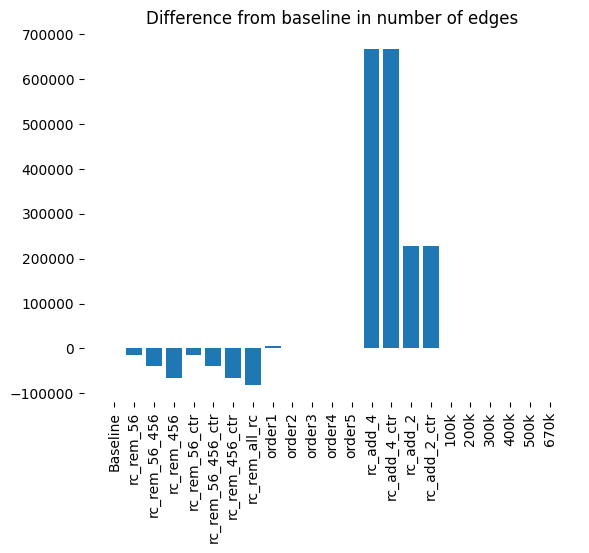

In [4]:
edge_diff={}
for key in sc.keys(): 
    edge_diff[key]=sc[key].loc[1]-sc["Baseline"].loc[1]
print("Number of edges diferent from baseline")
edge_diff=pd.DataFrame.from_dict(edge_diff, orient="index",columns=["counts"])
fig, axs = plt.subplots()
axs.bar(x=range(len(edge_diff)), height=edge_diff['counts'].to_numpy())
axs.set_xticks(range(len(edge_diff)), edge_diff.index, rotation=90)
axs.set_title("Difference from baseline in number of edges")
axs.spines[["top", "right", "left", "bottom"]].set_visible(False)

# Visual inspection and testing

In [9]:
def plot_kde(ax, models, cmap, plot_baseline=True,
             linewidth=3, linewidth_base=2, labelsize=14, ticksize=12, vmin=0.2, vmax=0.9):
    colors = cmap(np.linspace(vmin, vmax,len(models)))
    for i, model in enumerate(models):
        x=rels[model]
        x=x[~np.isnan(x)]
        plot=sns.kdeplot(x, label=model,ax=ax, c=colors[i],linewidth=linewidth)
    if plot_baseline: 
        for i, model in enumerate(models_base):
            x=rels[model]
            x=x[~np.isnan(x)]
            sns.kdeplot(x, label='baseline',ax=ax, c='k', alpha=0.6,linewidth=linewidth_base,linestyle='dotted')
    ax.set_xlabel("Reliability",fontsize=labelsize)
    ax.spines[["top","right"]].set_visible(False)
    ax.tick_params(labelsize=ticksize)
    return ax
def plot_sc(ax, models, cmap, plot_baseline=True,
             linewidth=3, linewidth_base=2, labelsize=14, ticksize=12, vmin=0.2, vmax=0.9):
    colors = cmap(np.linspace(vmin, vmax,len(models)))
    for i, model in enumerate(models):
        ax.plot(sc[model], label=model,c=colors[i],linewidth=linewidth)
    if plot_baseline: 
        ax.plot(sc['Baseline'], label='baseline',c='k',linewidth=linewidth_base,linestyle='dotted')
    ax.set_xlabel("Dimension",fontsize=labelsize)
    ax.spines[["top","right"]].set_visible(False)
    ax.tick_params(labelsize=ticksize)
    return ax

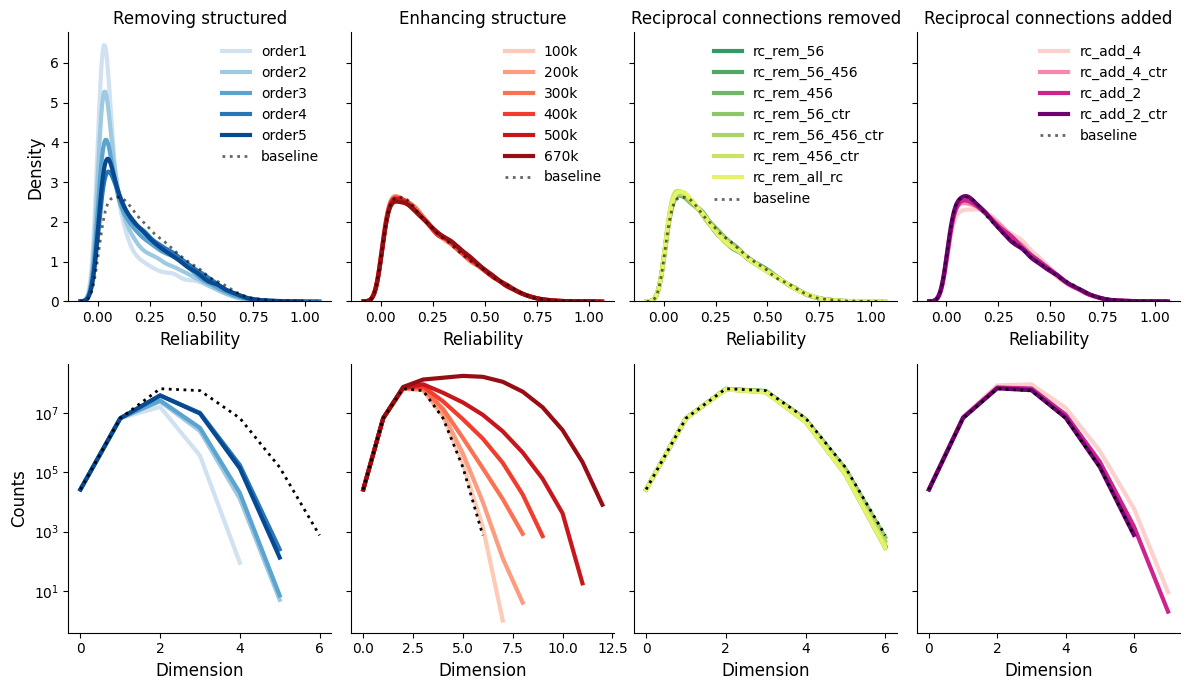

In [10]:
labelsize=12; ticksize=10
fig, axs = plt.subplots(2,4, figsize=(12,7),sharey='row')
cmaps=[plt.cm.Blues, plt.cm.Reds, plt.cm.summer, plt.cm.RdPu]
for j, models in enumerate([models_distance,models_enhanced, models_remove, models_add]):
    i=0 # Reliability 
    axs[i,j] = plot_kde(axs[i,j], models, cmaps[j],labelsize=labelsize,ticksize=ticksize)
    axs[i,j].legend(frameon=False)
    i=1 # Simplex counts 
    axs[i,j] = plot_sc(axs[i,j], models, cmaps[j],labelsize=labelsize,ticksize=ticksize)
    axs[i,j].set_yscale("log")
axs[0,0].set_ylabel("Density",fontsize=labelsize) 
axs[1,0].set_ylabel("Counts",fontsize=labelsize) 

axs[0,0].set_title("Removing structured", fontsize=labelsize)
axs[0,1].set_title("Enhancing structure", fontsize=labelsize)
axs[0,2].set_title("Reciprocal connections removed", fontsize=labelsize)
axs[0,3].set_title("Reciprocal connections added", fontsize=labelsize)
plt.tight_layout()

In [11]:
def plot_mean_median(ax, x, y, models, cmap, labelsize=14, s=20, vmin=0.2, vmax=0.9):
    n=len(models)
    colors = cmap(np.linspace(vmin, vmax,len(models)))
    ax.scatter(x.loc[models],y.loc[models],c=colors,s=20)
    min_v=min(x.min(), y.min())-0.01
    max_v=max(x.max(), y.max())+0.01
    ax.set_xlim(min_v, max_v)
    ax.set_ylim(min_v, max_v)
    return ax

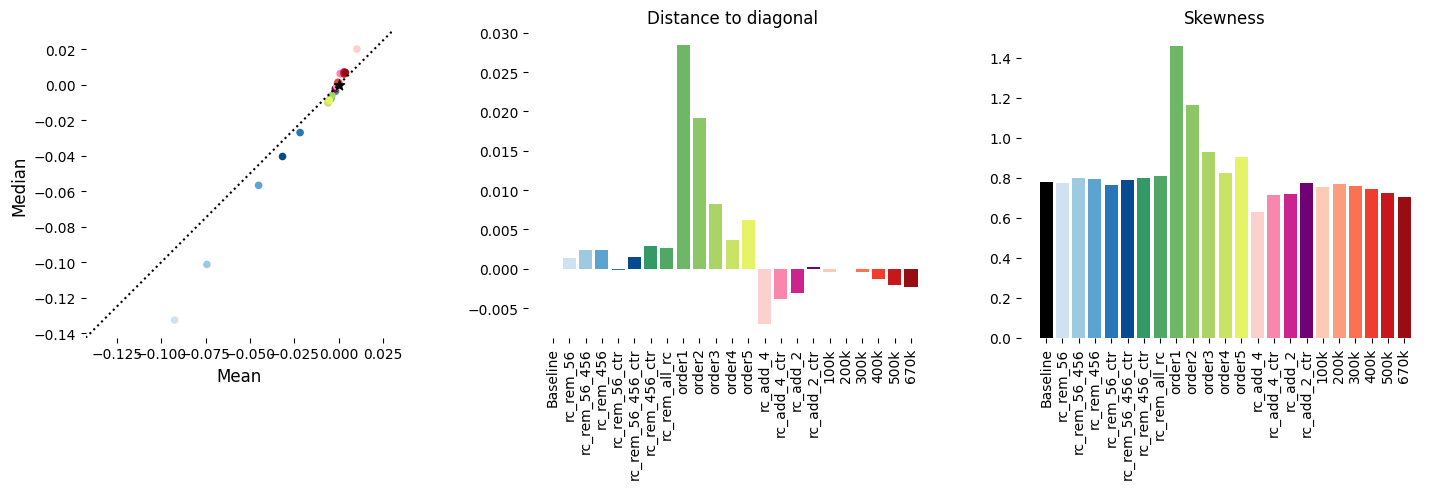

In [15]:
vmin=0.2;  vmax=0.9
# Setting up colors
models_dict={
    'remove':{
        'cmap':plt.cm.summer,
        'models': models_remove},
    'distance':{
        'cmap':plt.cm.Blues, 
        'models':models_distance},
    'add':{
        'cmap':plt.cm.RdPu,
        'models': models_add
    },
    'enhanced':{
        'cmap':plt.cm.Reds,
        'models': models_enhanced
    }
}

colors = np.vstack([[0,0,0,1]]+
                   [models_dict[key]['cmap'](np.linspace(vmin, vmax,len(models_dict[key]['models']))) 
                    for key in ['distance','remove',  'add', 'enhanced']])
fig, axs = plt.subplots(1,3, figsize=(15,5))
# Plotting median vs mean 
x=rels.mean(); y=rels.median()
x=x-x.Baseline; y=y-y.Baseline
axs[0].axline((np.min([x.min(), y.min()]), np.min([x.min(), y.min()])), slope=1, color="black", linestyle="dotted")
cmaps=[plt.cm.Blues, plt.cm.summer, plt.cm.RdPu]
axs[0].set_aspect('equal')



for key in models_dict.keys():
    plot_mean_median(axs[0],x, y,models_dict[key]['models'], models_dict[key]['cmap'], 
                     labelsize=14, s=40, vmin=vmin, vmax=vmax)
axs[0].scatter(x.loc["Baseline"], y.loc["Baseline"], s=60, color="black", marker="*")
axs[0].set_xlabel("Mean", fontsize=labelsize)
axs[0].set_ylabel("Median", fontsize=labelsize)
axs[0].set_aspect("equal")
axs[0].spines[:].set_visible(False)


# Plotting distance to diagonal and skewness 
heights=[(x-y)/np.sqrt(2),
         rels.apply(lambda x: stats.skew(x, nan_policy='omit'), axis=0)]
for i, height in enumerate(heights): 
    axs[i+1].bar(x=range(len(height)), height=height, color=colors)
    axs[i+1].set_xticks(range(len(edge_diff)), edge_diff.index, rotation=90)
    axs[i+1].spines[["top", "right", "left", "bottom"]].set_visible(False)
axs[1].set_title("Distance to diagonal")
axs[2].set_title("Skewness")
plt.tight_layout()

# Statistical tests

In [16]:
# Checking for mulitvariate difference 
samples={}
for model, x in rels.items():
    x=x.to_numpy()
    #samples[model]=(x[~np.isnan(x)])
    samples[model]=(x)
print(" Global Kruskal-Wallis H-test", stats.kruskal(*list(samples.values()),nan_policy='omit'))
# Post-hoc pairwise comparison
models=list(samples.keys())
pvals_ttest=pd.DataFrame(index=pd.MultiIndex.from_tuples(list(itertools.combinations(models,r=2))),
                  columns=['pvalue']).astype(float)
pvals_kruskal=pvals_ttest.copy()
for model_1,model_2 in pvals_kruskal.index:
    pvals_kruskal.loc[(model_1,model_2)]=stats.kruskal(*[samples[model_1], samples[model_2]], 
                                                       nan_policy= 'omit').pvalue.astype(float)
    pvals_ttest.loc[(model_1,model_2)]=stats.ttest_ind(*[samples[model_1], samples[model_2]], 
                                                       nan_policy='omit').pvalue.astype(float)

 Global Kruskal-Wallis H-test KruskalResult(statistic=12336.62215308822, pvalue=0.0)


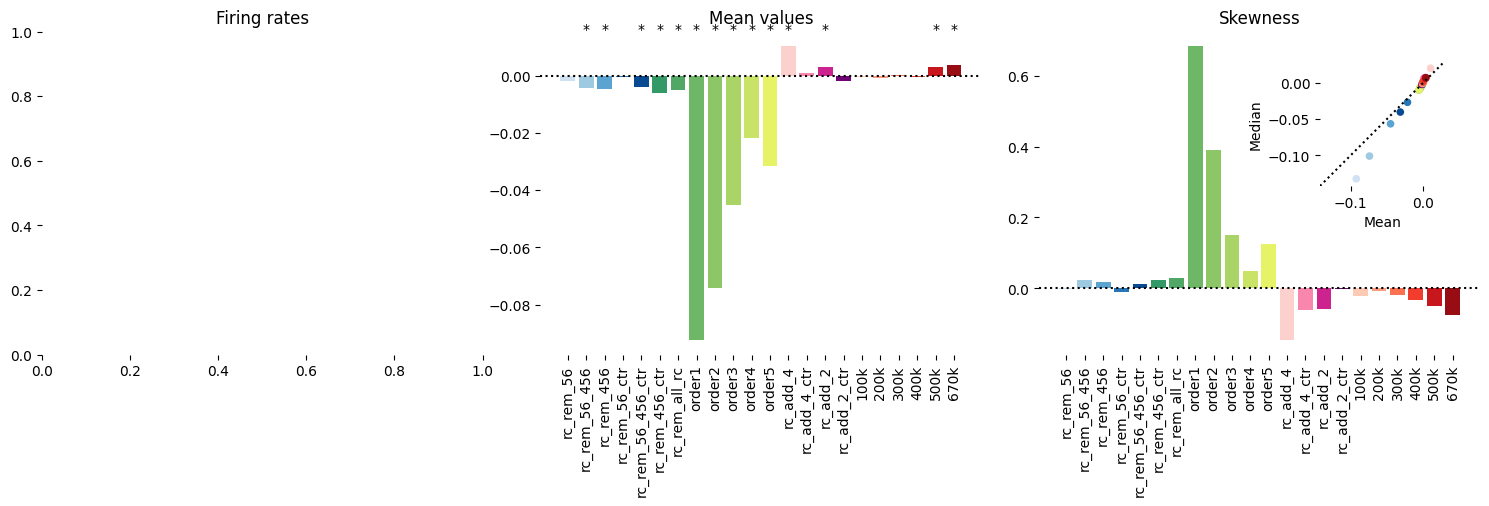

In [18]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

# Skewness
height=rels.apply(lambda x: stats.skew(x, nan_policy='omit'), axis=0)
height=height-height.Baseline
axs[2].bar(x=range(len(height)-1), height=height[1:], color=colors[1:])
axs[2].set_xticks(range(len(edge_diff)-1), edge_diff.index[1:], rotation=90)
axs[2].axline((0,height.Baseline), slope=0, color="black", linestyle="dotted")
plt.tight_layout()

# Mean values 
barme=rels.mean(axis=0)
barme=barme-barme.Baseline
axs[1].bar(x=np.arange(len(barme)-1), height=barme.to_numpy()[1:], color=colors[1:])
axs[1].set_xticks(np.arange(len(barme)-1), labels=barme.index[1:], rotation=90)
axs[1].axline((0,barme.Baseline), slope=0, color="black", linestyle="dotted")
#axs[1].set_ylim(0.1, 0.255)
# Adding markers for the connectomes that not statitically different than the
thresh=0.05
test_fail=pvals_kruskal.xs("Baseline", level=0) 
test_fail=np.arange(len(test_fail))[(test_fail<thresh)['pvalue'].to_numpy()]
y_mean=0.015; y_skew=0.7
for x in test_fail:
    axs[1].text(x, y_mean,"*", horizontalalignment='center')
    #axs[2].text(x, y_skew,"*", horizontalalignment='center')

# Titles 
axs[0].set_title("Firing rates",fontsize=labelsize)
axs[1].set_title("Mean values",fontsize=labelsize)
axs[2].set_title("Skewness",fontsize=labelsize)

# Inset mean vs. median 
#Make axis
left, bottom, width, height = [0.8, 0.65, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
# Plotting median vs mean 
x=rels.mean(); y=rels.median()
x=x-x.Baseline; y=y-y.Baseline
ax2.axline((np.min([x.min(), y.min()]), np.min([x.min(), y.min()])), slope=1, color="black", linestyle="dotted")
cmaps=[plt.cm.Blues, plt.cm.summer, plt.cm.RdPu] #remove me somehow
ax2.set_aspect('equal')
for key in models_dict.keys():
    plot_mean_median(ax2,x, y,models_dict[key]['models'], models_dict[key]['cmap'], 
                     labelsize=14, s=40, vmin=vmin, vmax=vmax)
ax2.set_xlabel("Mean", fontsize=ticksize)
ax2.set_ylabel("Median", fontsize=ticksize)
ax2.spines[:].set_visible(False)

for ax in axs.flatten():
    ax.spines[:].set_visible(False)

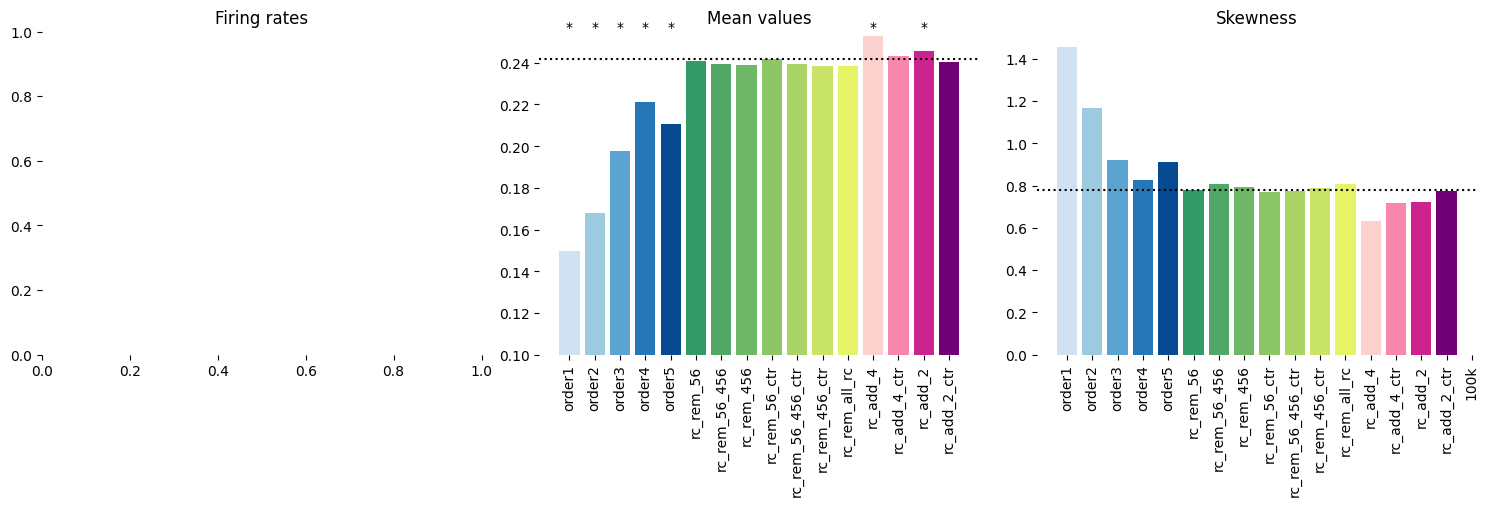

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

# Skewness
height=rels.apply(lambda x: stats.skew(x, nan_policy='omit'), axis=0)
axs[2].bar(x=range(len(height)-1), height=height[1:], color=colors[1:])
axs[2].set_xticks(range(len(edge_diff)-1), edge_diff.index[1:], rotation=90)
axs[2].axline((0,height.Baseline), slope=0, color="black", linestyle="dotted")
plt.tight_layout()

# Mean values 
barme=rels.mean(axis=0)
axs[1].bar(x=np.arange(len(barme)-1), height=barme.to_numpy()[1:], color=colors[1:])
axs[1].set_xticks(np.arange(len(barme)-1), labels=barme.index[1:], rotation=90)
axs[1].axline((0,barme.Baseline), slope=0, color="black", linestyle="dotted")
axs[1].set_ylim(0.1, 0.255)
# Adding markers for the connectomes that not statitically different than the
thresh=0.01
test_fail=pvals_kruskal.xs("Baseline", level=0) 
test_fail=np.arange(len(test_fail))[(test_fail<thresh)['pvalue'].to_numpy()]
y=0.255
for x in test_fail:
    axs[1].text(x, y,"*", horizontalalignment='center')

# Titles 
axs[0].set_title("Firing rates",fontsize=labelsize)
axs[1].set_title("Mean values",fontsize=labelsize)
axs[2].set_title("Skewness",fontsize=labelsize)


for ax in axs.flatten():
    ax.spines[:].set_visible(False)

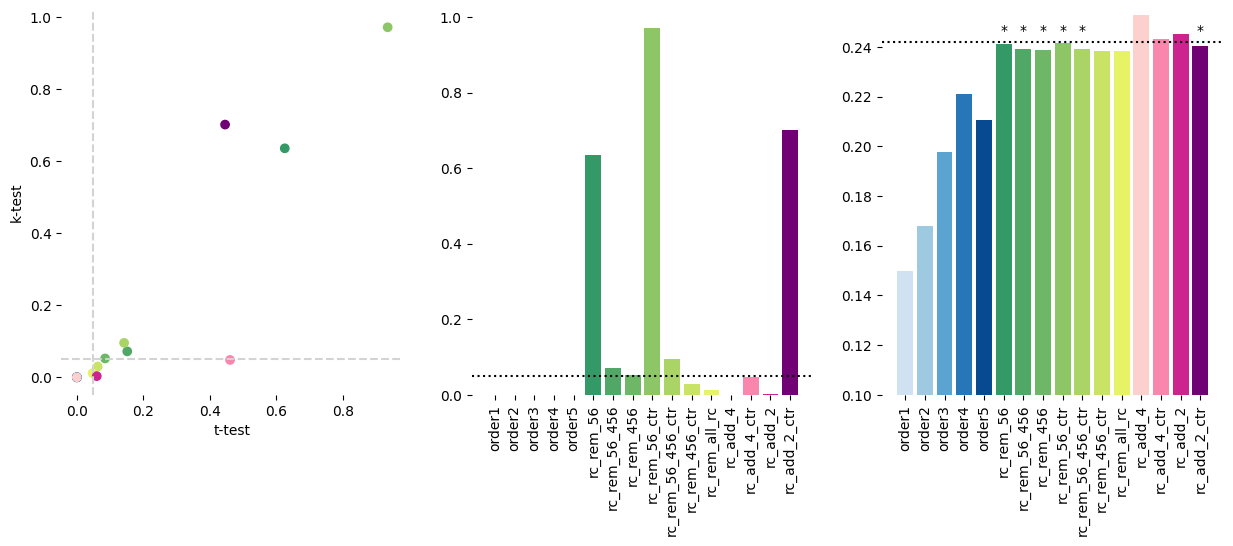

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
thresh=0.05
# Scatter comparison 
axs[0].axline((0,thresh), slope=0,color="lightgrey", linestyle="dashed")
axs[0].axline((thresh, 0), slope=np.inf,color="lightgrey", linestyle="dashed")
axs[0].scatter(pvals_ttest.xs("Baseline", level=0), pvals_kruskal.xs("Baseline", level=0), color=colors[1:])
axs[0].set_xlabel('t-test')
axs[0].set_ylabel('k-test')

# Values of stat tests 
barme=pvals_kruskal.xs('Baseline', level=0)
axs[1].bar(x=np.arange(len(barme)), height=barme['pvalue'].to_numpy(), color=colors[1:])
axs[1].set_xticks(np.arange(len(barme)), labels=barme.index, rotation=90)
axs[1].axline((0,thresh), slope=0, color="black", linestyle="dotted")

# Mean values 
barme=rels.mean(axis=0)
axs[2].bar(x=np.arange(len(barme)-1), height=barme.to_numpy()[1:], color=colors[1:])
axs[2].set_xticks(np.arange(len(barme)-1), labels=barme.index[1:], rotation=90)
axs[2].axline((0,barme.Baseline), slope=0, color="black", linestyle="dotted")
axs[2].set_ylim(0.1, 0.255)
# Adding markers for the connectomes that not statitically different than the
test_fail=pvals_kruskal.xs("Baseline", level=0) 
test_fail=np.arange(len(test_fail))[(test_fail>thresh)['pvalue'].to_numpy()]
y=0.245
for x in test_fail:
    axs[2].text(x, y,"*", horizontalalignment='center')
    

for ax in axs.flatten():
    ax.spines[:].set_visible(False)

Text(0, 0.5, 'k-test')

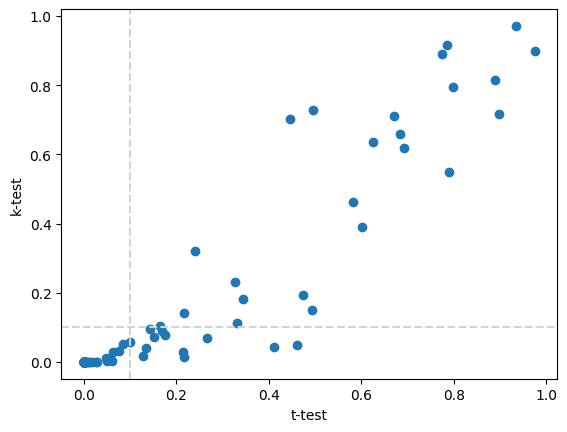

In [14]:
fig, axs = plt.subplots()
#axs.axline((0,0), slope=1, color="lightgrey", linestyle="dashed")
thresh=0.1
axs.axline((0,thresh), slope=0,color="lightgrey", linestyle="dashed")
axs.axline((thresh, 0), slope=np.inf,color="lightgrey", linestyle="dashed")
axs.scatter(pvals_ttest, pvals_kruskal)
axs.set_xlabel('t-test')
axs.set_ylabel('k-test')

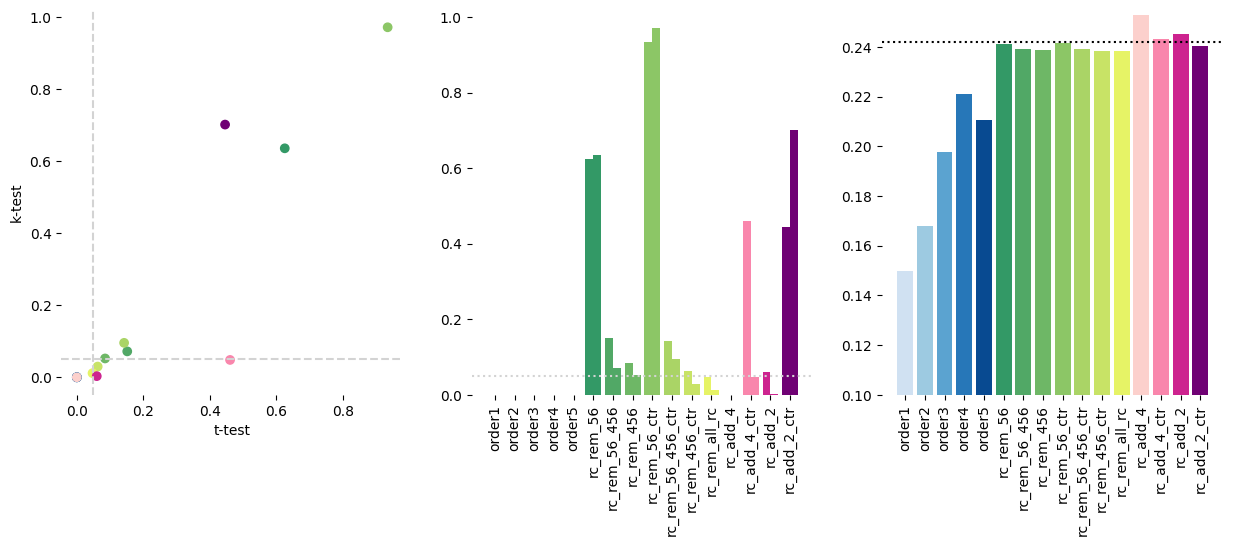

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
thresh=0.05
# Scatter comparison 
axs[0].axline((0,thresh), slope=0,color="lightgrey", linestyle="dashed")
axs[0].axline((thresh, 0), slope=np.inf,color="lightgrey", linestyle="dashed")
axs[0].scatter(pvals_ttest.xs("Baseline", level=0), pvals_kruskal.xs("Baseline", level=0), color=colors[1:])
axs[0].set_xlabel('t-test')
axs[0].set_ylabel('k-test')

# Values of stat tests 
barme=pvals_ttest.xs('Baseline', level=0)
axs[1].bar(x=np.arange(len(barme))-0.2, height=barme['pvalue'].to_numpy(), width=0.4, color=colors[1:])
barme=pvals_kruskal.xs('Baseline', level=0)
axs[1].bar(x=np.arange(len(barme))+0.2, height=barme['pvalue'].to_numpy(),width=0.4,color=colors[1:])

axs[1].set_xticks(np.arange(len(barme)), labels=barme.index, rotation=90)
axs[1].axline((0,thresh), slope=0, color="lightgrey", linestyle="dotted")

# Mean values 
barme=rels.mean(axis=0)
axs[2].bar(x=np.arange(len(barme)-1), height=barme.to_numpy()[1:], color=colors[1:])
axs[2].set_xticks(np.arange(len(barme)-1), labels=barme.index[1:], rotation=90)
axs[2].axline((0,barme.Baseline), slope=0, color="black", linestyle="dotted")
axs[2].set_ylim(0.1, 0.255)

for ax in axs.flatten():
    ax.spines[:].set_visible(False)


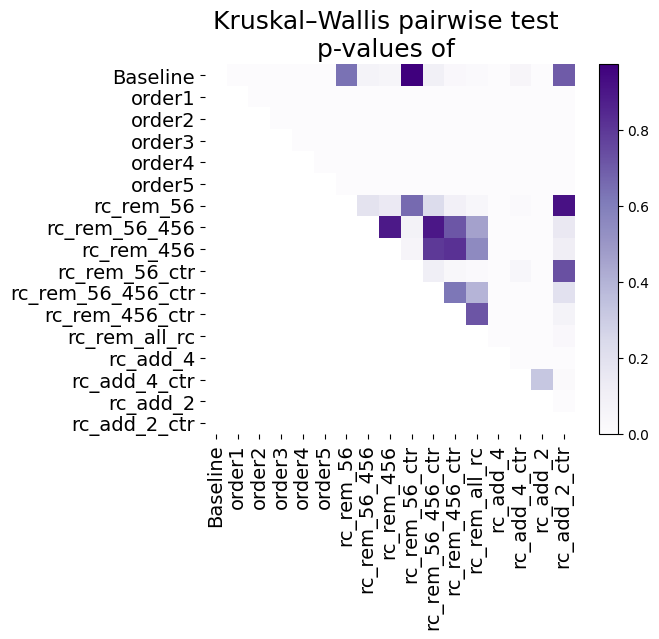

In [16]:
plotme=np.full((len(models),len(models)), np.nan)
plotme[np.triu_indices(len(models),k=1)]=pvals_kruskal['pvalue'].to_numpy()
fig, axs = plt.subplots()
plot=axs.imshow(plotme,cmap='Purples')
plt.colorbar(plot,ax=axs)
axs.set_xticks(range(len(models)))
axs.set_xticklabels(models, rotation=90,fontsize=14)
axs.set_yticks(range(len(models)))
axs.set_yticklabels(models, rotation=0,fontsize=14)
axs.set_title("Kruskal–Wallis pairwise test \np-values of ",fontsize=18)
plt.box(False)
#fig.savefig("figsCNS/p_values_all.pdf", transparent=True, dpi=300,bbox_inches='tight' )

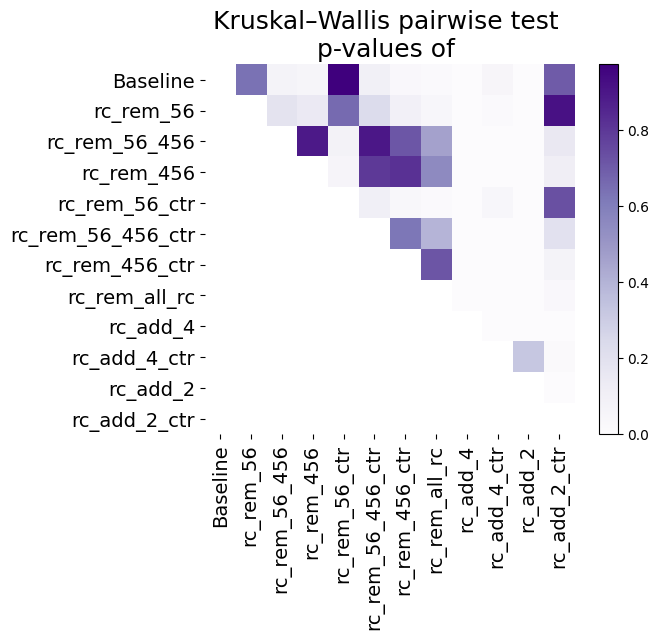

In [17]:
res= np.append(0, np.arange(11)+6) #Indices of model subselection 
fig, axs = plt.subplots()
plotme_res=plotme[np.ix_(res,res)]
plot=axs.imshow(plotme_res, cmap="Purples")
plt.colorbar(plot,ax=axs)
axs.set_xticks(range(len(res)))
axs.set_xticklabels(np.array(models)[res], rotation=90,fontsize=14)
axs.set_yticks(range(len(res)))
axs.set_yticklabels(np.array(models)[res], rotation=0,fontsize=14)
axs.set_title("Kruskal–Wallis pairwise test \np-values of ",fontsize=18)
plt.box(False)

(0.1, 0.255)

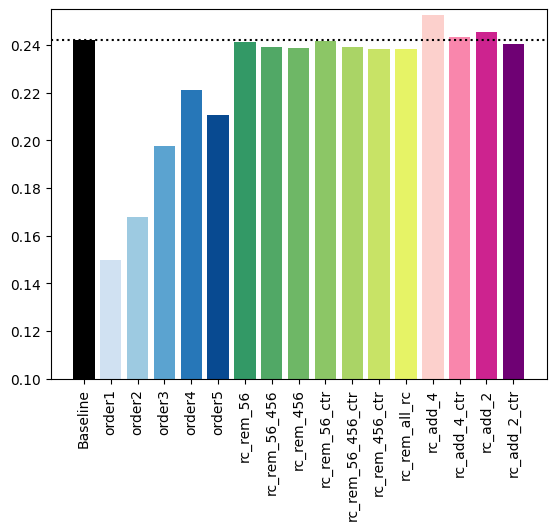

In [18]:
fig, axs = plt.subplots()
barme=rels.mean(axis=0)
axs.bar(x=np.arange(len(barme)), height=barme.to_numpy(), color=colors)
axs.set_xticks(np.arange(len(barme)), labels=barme.index, rotation=90)
axs.axline((0,barme.Baseline), slope=0, color="black", linestyle="dotted")
axs.set_ylim(0.1, 0.255)